[Episode 0] Steps: 100, Total attached: 96, Success: True


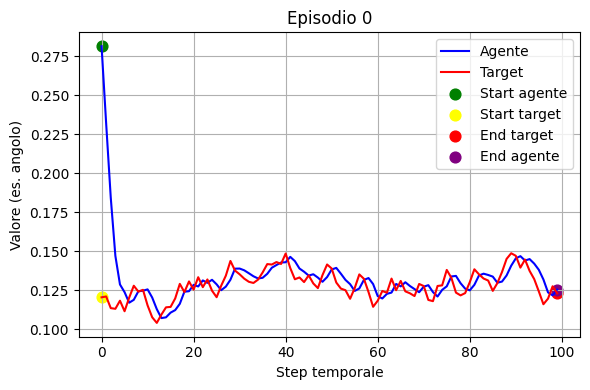

[Episode 1] Steps: 100, Total attached: 12, Success: False


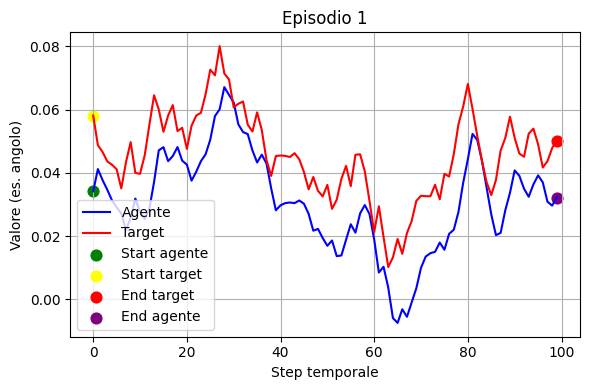

[Episode 2] Steps: 100, Total attached: 0, Success: False


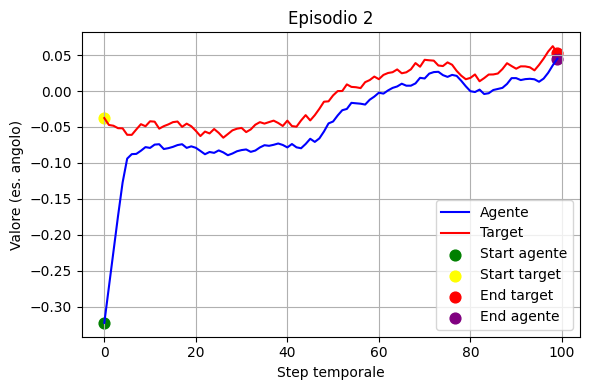

[Episode 3] Steps: 100, Total attached: 1, Success: False


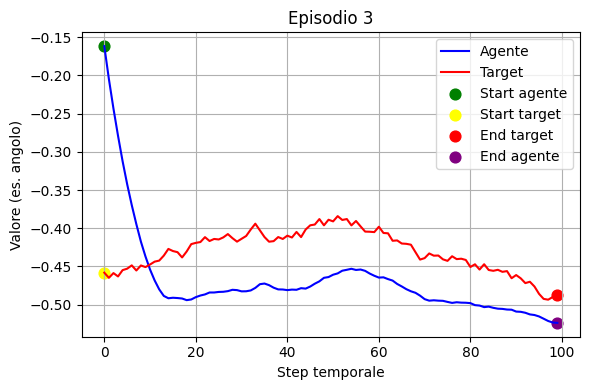

[Episode 4] Steps: 100, Total attached: 3, Success: False


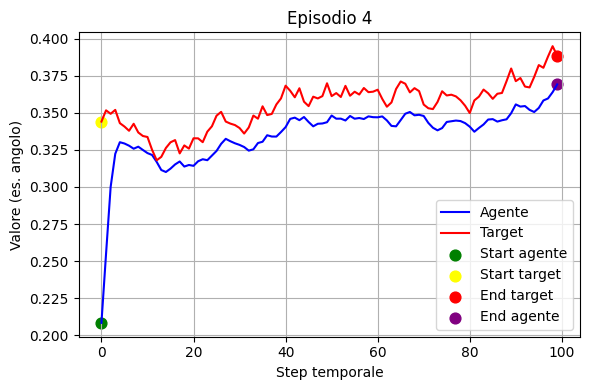

[Episode 5] Steps: 100, Total attached: 43, Success: False


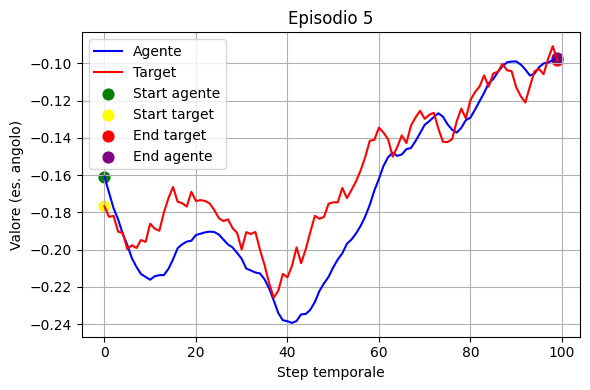

[Episode 6] Steps: 100, Total attached: 32, Success: False


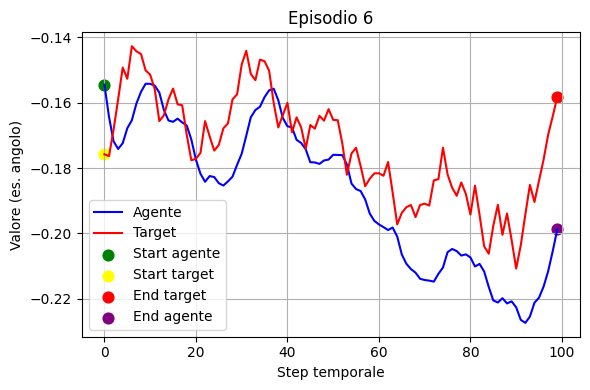

[Episode 7] Steps: 100, Total attached: 2, Success: False


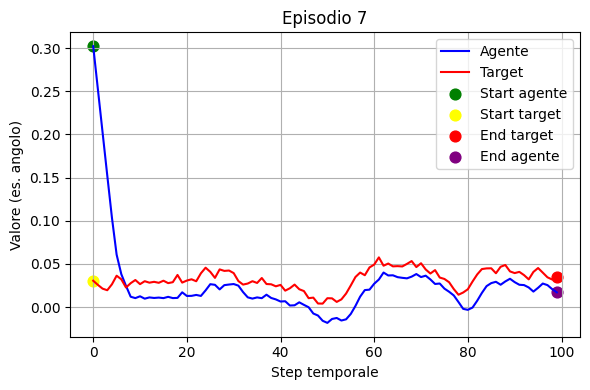

[Episode 8] Steps: 100, Total attached: 52, Success: False


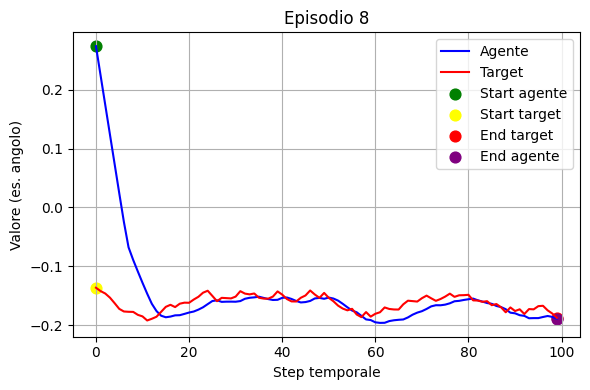

[Episode 9] Steps: 100, Total attached: 2, Success: False


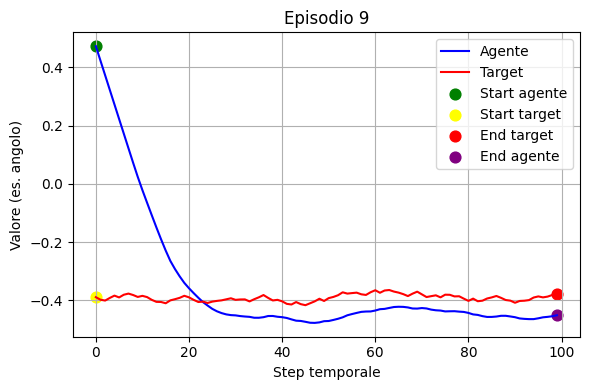


Media step attaccati: 24.30
Successi (attaccato per ≥ 20 step): 1 / 10


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            if torch.abs(real_next_state[0] - real_state[1]) < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = attached_counter > 80
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 20 step): {success_counter} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward.zip"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 0, Mean distance: 0.0405, Success: False


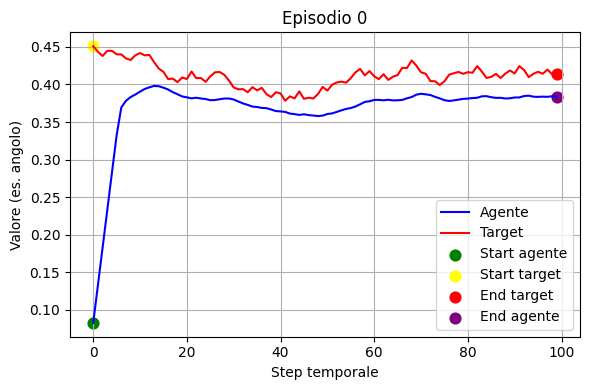

[Episode 1] Steps: 100, Total attached: 39, Mean distance: 0.0341, Success: False


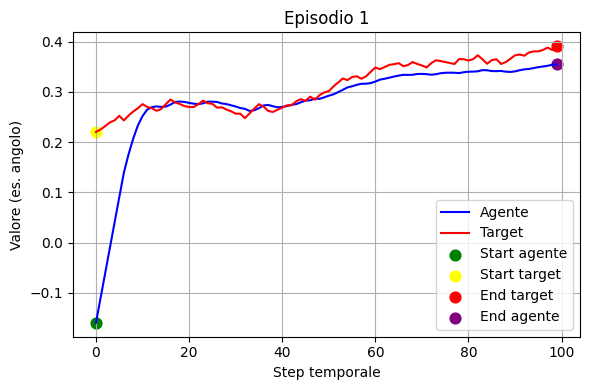

[Episode 2] Steps: 100, Total attached: 11, Mean distance: 0.0294, Success: False


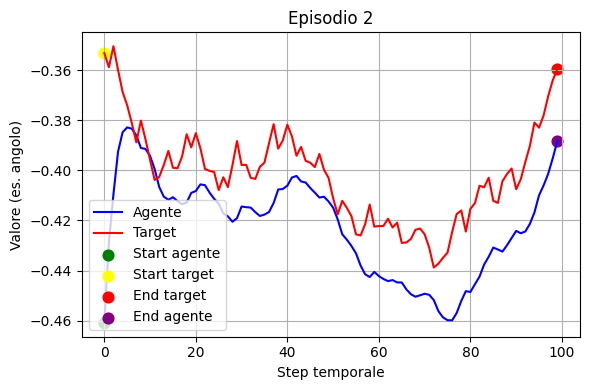

[Episode 3] Steps: 100, Total attached: 16, Mean distance: 0.0415, Success: False


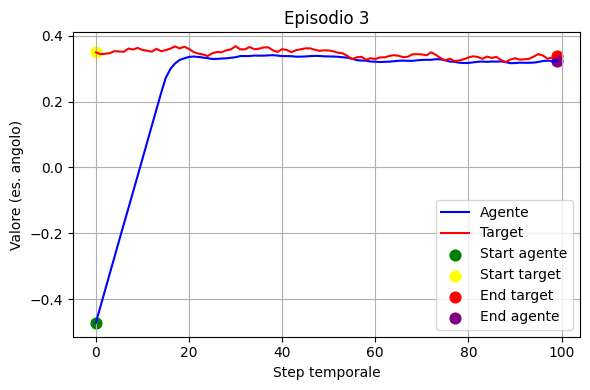

[Episode 4] Steps: 100, Total attached: 72, Mean distance: 0.0451, Success: False


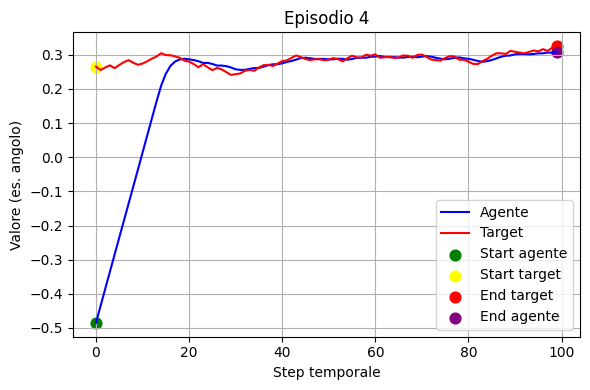

[Episode 5] Steps: 100, Total attached: 67, Mean distance: 0.0391, Success: False


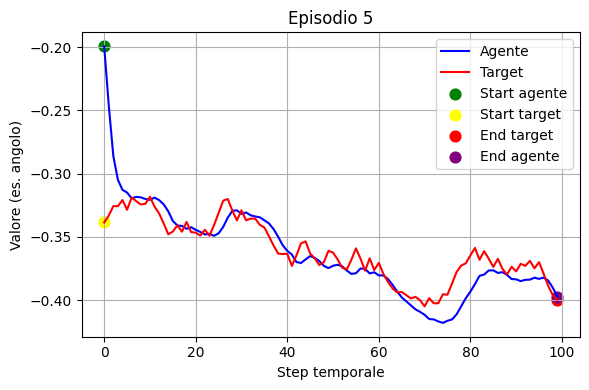

[Episode 6] Steps: 100, Total attached: 0, Mean distance: 0.0439, Success: False


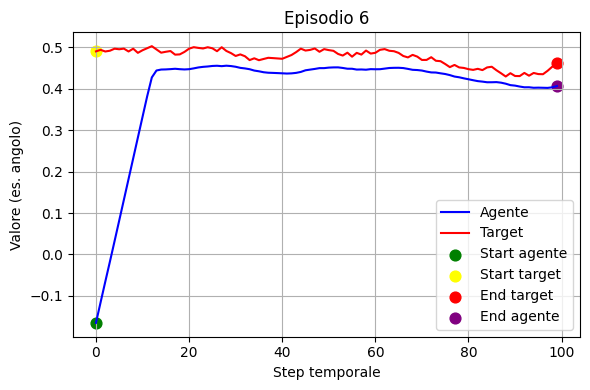

[Episode 7] Steps: 100, Total attached: 78, Mean distance: 0.0414, Success: False


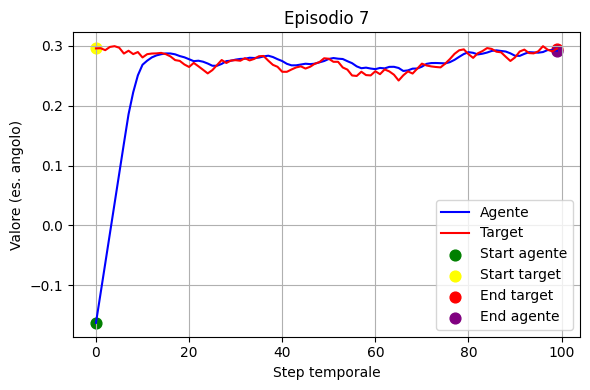

[Episode 8] Steps: 100, Total attached: 49, Mean distance: 0.0384, Success: False


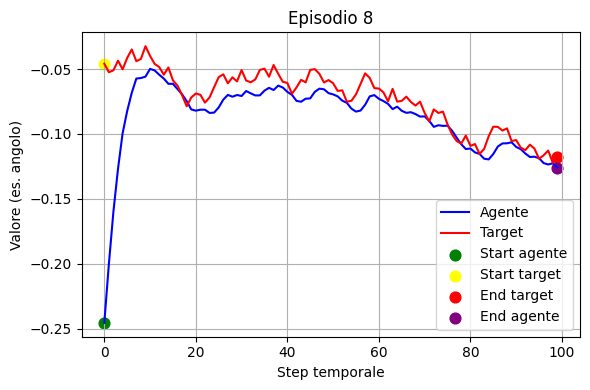

[Episode 9] Steps: 100, Total attached: 41, Mean distance: 0.0356, Success: False


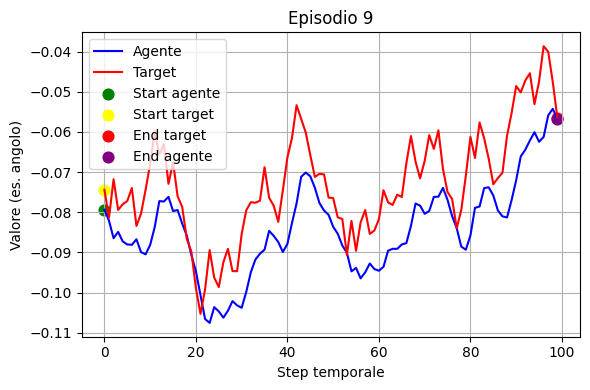


Media step attaccati: 37.30
Successi (attaccato per ≥ 80 step): 0 / 10
Media distanza episodio: 0.0389


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 94, Mean distance: 0.0116, Success: True


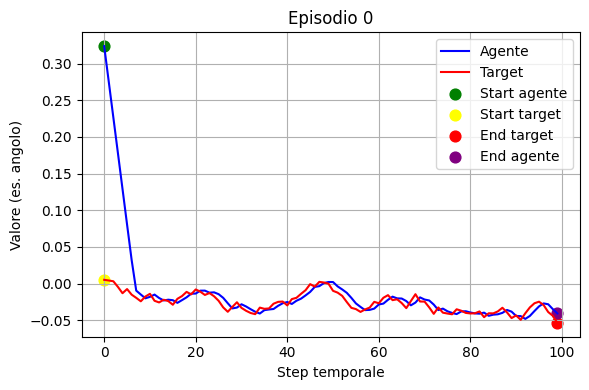

[Episode 1] Steps: 100, Total attached: 92, Mean distance: 0.0152, Success: True
[Episode 2] Steps: 100, Total attached: 92, Mean distance: 0.0157, Success: True
[Episode 3] Steps: 100, Total attached: 95, Mean distance: 0.0138, Success: True
[Episode 4] Steps: 100, Total attached: 99, Mean distance: 0.0116, Success: True
[Episode 5] Steps: 100, Total attached: 94, Mean distance: 0.0108, Success: True
[Episode 6] Steps: 100, Total attached: 100, Mean distance: 0.0097, Success: True
[Episode 7] Steps: 100, Total attached: 82, Mean distance: 0.0189, Success: True
[Episode 8] Steps: 100, Total attached: 99, Mean distance: 0.0169, Success: True
[Episode 9] Steps: 100, Total attached: 97, Mean distance: 0.0156, Success: True
[Episode 10] Steps: 100, Total attached: 82, Mean distance: 0.0151, Success: True
[Episode 11] Steps: 100, Total attached: 95, Mean distance: 0.0142, Success: True
[Episode 12] Steps: 100, Total attached: 99, Mean distance: 0.0134, Success: True
[Episode 13] Steps: 100,

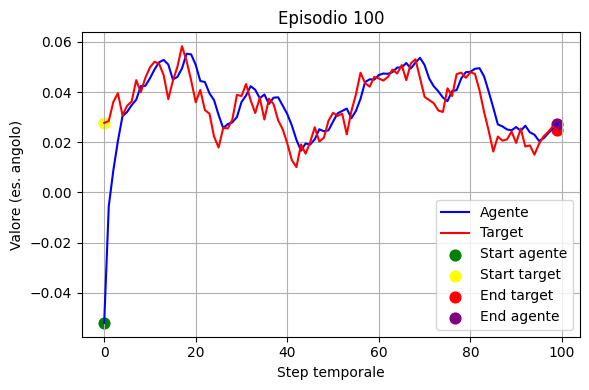

[Episode 101] Steps: 100, Total attached: 95, Mean distance: 0.0205, Success: True
[Episode 102] Steps: 100, Total attached: 93, Mean distance: 0.0204, Success: True
[Episode 103] Steps: 100, Total attached: 84, Mean distance: 0.0205, Success: True
[Episode 104] Steps: 100, Total attached: 90, Mean distance: 0.0206, Success: True
[Episode 105] Steps: 100, Total attached: 85, Mean distance: 0.0206, Success: True
[Episode 106] Steps: 100, Total attached: 84, Mean distance: 0.0209, Success: True
[Episode 107] Steps: 100, Total attached: 94, Mean distance: 0.0208, Success: True
[Episode 108] Steps: 100, Total attached: 92, Mean distance: 0.0208, Success: True
[Episode 109] Steps: 100, Total attached: 94, Mean distance: 0.0207, Success: True
[Episode 110] Steps: 100, Total attached: 87, Mean distance: 0.0207, Success: True
[Episode 111] Steps: 100, Total attached: 77, Mean distance: 0.0208, Success: False
[Episode 112] Steps: 100, Total attached: 88, Mean distance: 0.0210, Success: True
[Ep

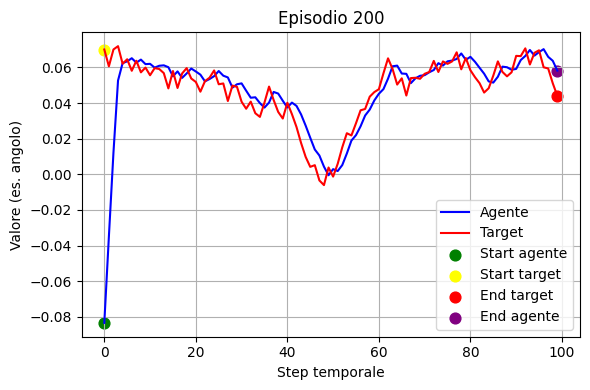

[Episode 201] Steps: 100, Total attached: 97, Mean distance: 0.0184, Success: True
[Episode 202] Steps: 100, Total attached: 79, Mean distance: 0.0188, Success: False
[Episode 203] Steps: 100, Total attached: 91, Mean distance: 0.0188, Success: True
[Episode 204] Steps: 100, Total attached: 99, Mean distance: 0.0187, Success: True
[Episode 205] Steps: 100, Total attached: 85, Mean distance: 0.0188, Success: True
[Episode 206] Steps: 100, Total attached: 81, Mean distance: 0.0188, Success: True
[Episode 207] Steps: 100, Total attached: 81, Mean distance: 0.0188, Success: True
[Episode 208] Steps: 100, Total attached: 97, Mean distance: 0.0187, Success: True
[Episode 209] Steps: 100, Total attached: 99, Mean distance: 0.0187, Success: True
[Episode 210] Steps: 100, Total attached: 94, Mean distance: 0.0186, Success: True
[Episode 211] Steps: 100, Total attached: 100, Mean distance: 0.0185, Success: True
[Episode 212] Steps: 100, Total attached: 95, Mean distance: 0.0185, Success: True
[E

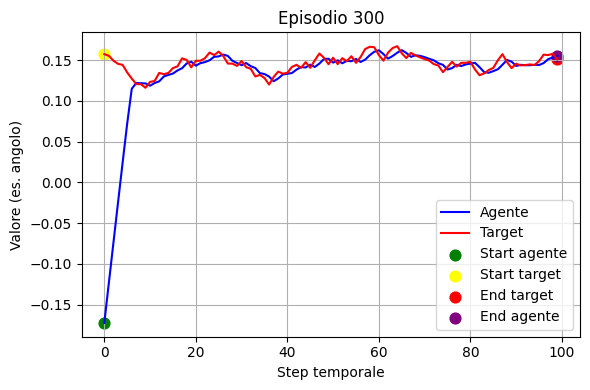

[Episode 301] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Episode 302] Steps: 100, Total attached: 95, Mean distance: 0.0191, Success: True
[Episode 303] Steps: 100, Total attached: 80, Mean distance: 0.0190, Success: False
[Episode 304] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 305] Steps: 100, Total attached: 97, Mean distance: 0.0190, Success: True
[Episode 306] Steps: 100, Total attached: 86, Mean distance: 0.0189, Success: True
[Episode 307] Steps: 100, Total attached: 87, Mean distance: 0.0190, Success: True
[Episode 308] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 309] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 310] Steps: 100, Total attached: 82, Mean distance: 0.0190, Success: True
[Episode 311] Steps: 100, Total attached: 90, Mean distance: 0.0190, Success: True
[Episode 312] Steps: 100, Total attached: 100, Mean distance: 0.0189, Success: True
[E

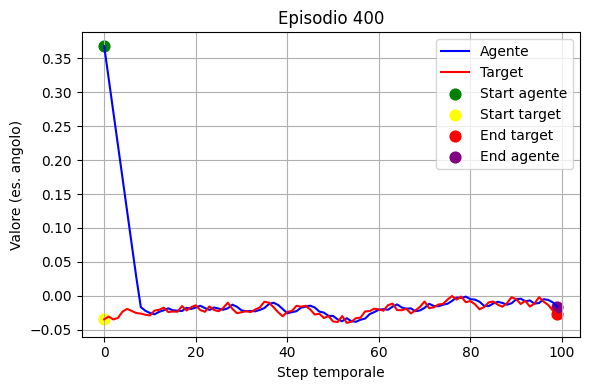

[Episode 401] Steps: 100, Total attached: 100, Mean distance: 0.0192, Success: True
[Episode 402] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 403] Steps: 100, Total attached: 98, Mean distance: 0.0192, Success: True
[Episode 404] Steps: 100, Total attached: 73, Mean distance: 0.0194, Success: False
[Episode 405] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 406] Steps: 100, Total attached: 97, Mean distance: 0.0193, Success: True
[Episode 407] Steps: 100, Total attached: 82, Mean distance: 0.0194, Success: True
[Episode 408] Steps: 100, Total attached: 99, Mean distance: 0.0194, Success: True
[Episode 409] Steps: 100, Total attached: 84, Mean distance: 0.0195, Success: True
[Episode 410] Steps: 100, Total attached: 98, Mean distance: 0.0194, Success: True
[Episode 411] Steps: 100, Total attached: 94, Mean distance: 0.0194, Success: True
[Episode 412] Steps: 100, Total attached: 96, Mean distance: 0.0194, Success: True
[E

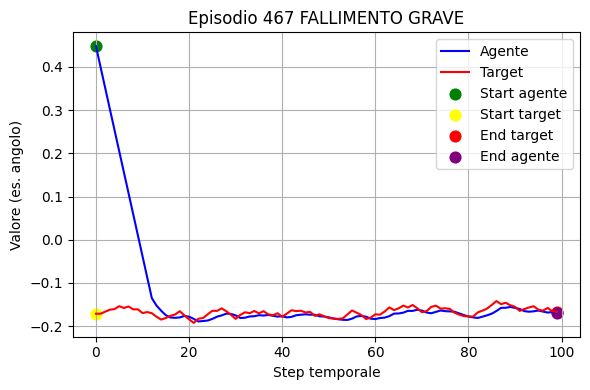

[Episode 467] Steps: 100, Total attached: 67, Mean distance: 0.0191, Success: False
[Episode 468] Steps: 100, Total attached: 93, Mean distance: 0.0191, Success: True
[Episode 469] Steps: 100, Total attached: 81, Mean distance: 0.0192, Success: True
[Episode 470] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 471] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 472] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 473] Steps: 100, Total attached: 99, Mean distance: 0.0191, Success: True
[Episode 474] Steps: 100, Total attached: 71, Mean distance: 0.0191, Success: False
[Episode 475] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 476] Steps: 100, Total attached: 75, Mean distance: 0.0191, Success: False
[Episode 477] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 478] Steps: 100, Total attached: 98, Mean distance: 0.0190, Success: True
[

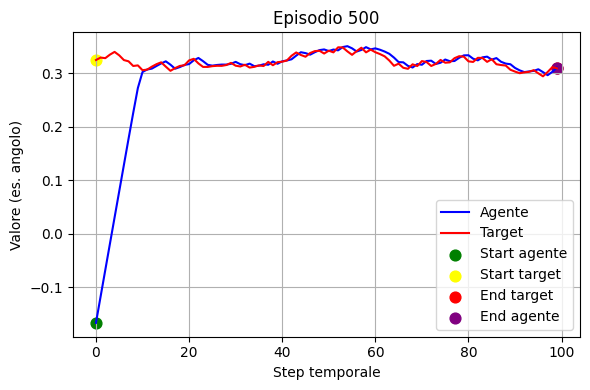

[Episode 501] Steps: 100, Total attached: 79, Mean distance: 0.0192, Success: False
[Episode 502] Steps: 100, Total attached: 97, Mean distance: 0.0192, Success: True
[Episode 503] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 504] Steps: 100, Total attached: 96, Mean distance: 0.0191, Success: True
[Episode 505] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 506] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 507] Steps: 100, Total attached: 75, Mean distance: 0.0191, Success: False
[Episode 508] Steps: 100, Total attached: 98, Mean distance: 0.0191, Success: True
[Episode 509] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 510] Steps: 100, Total attached: 80, Mean distance: 0.0191, Success: False
[Episode 511] Steps: 100, Total attached: 91, Mean distance: 0.0191, Success: True
[Episode 512] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[

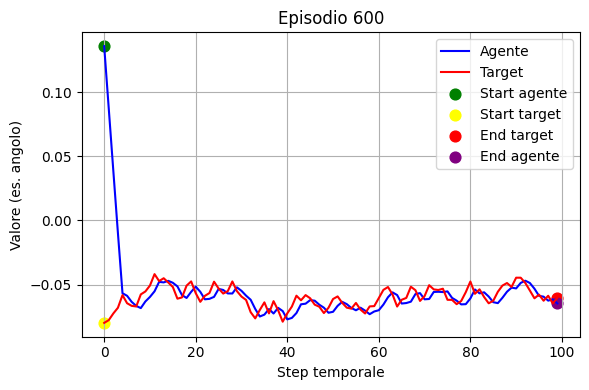

[Episode 601] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 602] Steps: 100, Total attached: 93, Mean distance: 0.0191, Success: True
[Episode 603] Steps: 100, Total attached: 100, Mean distance: 0.0191, Success: True
[Episode 604] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 605] Steps: 100, Total attached: 89, Mean distance: 0.0191, Success: True
[Episode 606] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 607] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 608] Steps: 100, Total attached: 96, Mean distance: 0.0191, Success: True
[Episode 609] Steps: 100, Total attached: 92, Mean distance: 0.0191, Success: True
[Episode 610] Steps: 100, Total attached: 90, Mean distance: 0.0191, Success: True
[Episode 611] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Episode 612] Steps: 100, Total attached: 87, Mean distance: 0.0191, Success: True
[Ep

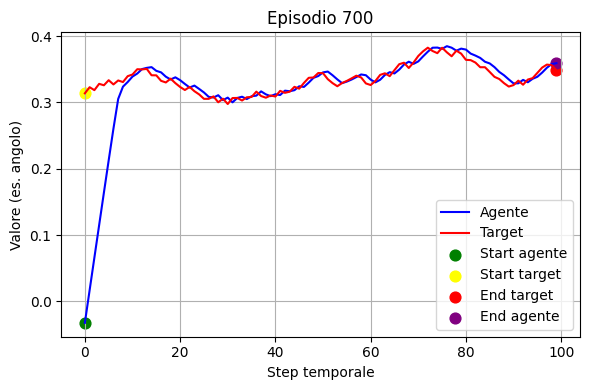

[Episode 701] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 702] Steps: 100, Total attached: 100, Mean distance: 0.0190, Success: True
[Episode 703] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 704] Steps: 100, Total attached: 86, Mean distance: 0.0191, Success: True
[Episode 705] Steps: 100, Total attached: 99, Mean distance: 0.0190, Success: True
[Episode 706] Steps: 100, Total attached: 94, Mean distance: 0.0190, Success: True
[Episode 707] Steps: 100, Total attached: 88, Mean distance: 0.0190, Success: True
[Episode 708] Steps: 100, Total attached: 95, Mean distance: 0.0190, Success: True
[Episode 709] Steps: 100, Total attached: 93, Mean distance: 0.0190, Success: True
[Episode 710] Steps: 100, Total attached: 91, Mean distance: 0.0190, Success: True
[Episode 711] Steps: 100, Total attached: 74, Mean distance: 0.0190, Success: False
[Episode 712] Steps: 100, Total attached: 86, Mean distance: 0.0190, Success: True
[E

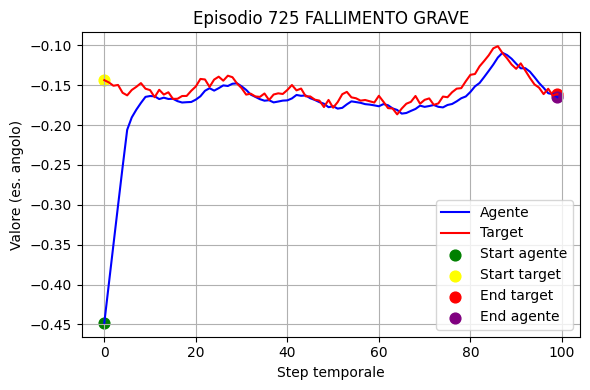

[Episode 725] Steps: 100, Total attached: 67, Mean distance: 0.0192, Success: False
[Episode 726] Steps: 100, Total attached: 97, Mean distance: 0.0192, Success: True
[Episode 727] Steps: 100, Total attached: 88, Mean distance: 0.0192, Success: True
[Episode 728] Steps: 100, Total attached: 81, Mean distance: 0.0193, Success: True
[Episode 729] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 730] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 731] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 732] Steps: 100, Total attached: 80, Mean distance: 0.0193, Success: False
[Episode 733] Steps: 100, Total attached: 96, Mean distance: 0.0192, Success: True
[Episode 734] Steps: 100, Total attached: 99, Mean distance: 0.0192, Success: True
[Episode 735] Steps: 100, Total attached: 94, Mean distance: 0.0192, Success: True
[Episode 736] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[E

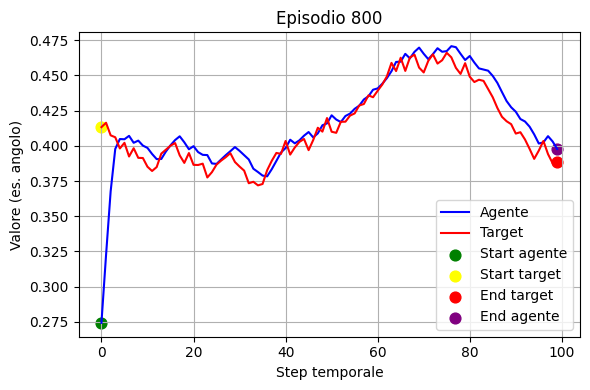

[Episode 801] Steps: 100, Total attached: 81, Mean distance: 0.0191, Success: True
[Episode 802] Steps: 100, Total attached: 88, Mean distance: 0.0191, Success: True
[Episode 803] Steps: 100, Total attached: 84, Mean distance: 0.0192, Success: True
[Episode 804] Steps: 100, Total attached: 94, Mean distance: 0.0192, Success: True
[Episode 805] Steps: 100, Total attached: 96, Mean distance: 0.0192, Success: True
[Episode 806] Steps: 100, Total attached: 79, Mean distance: 0.0192, Success: False
[Episode 807] Steps: 100, Total attached: 93, Mean distance: 0.0192, Success: True
[Episode 808] Steps: 100, Total attached: 82, Mean distance: 0.0192, Success: True
[Episode 809] Steps: 100, Total attached: 92, Mean distance: 0.0192, Success: True
[Episode 810] Steps: 100, Total attached: 87, Mean distance: 0.0193, Success: True
[Episode 811] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Episode 812] Steps: 100, Total attached: 90, Mean distance: 0.0193, Success: True
[Ep

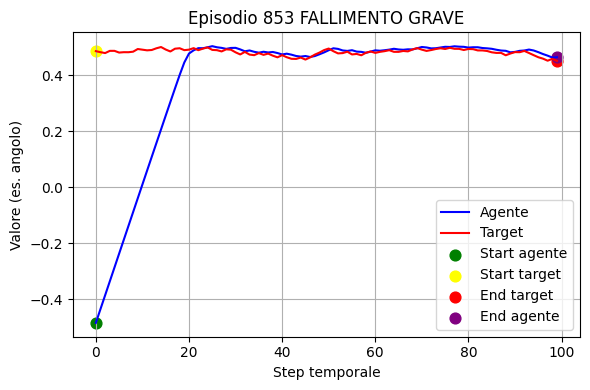

[Episode 853] Steps: 100, Total attached: 69, Mean distance: 0.0193, Success: False
[Episode 854] Steps: 100, Total attached: 98, Mean distance: 0.0193, Success: True
[Episode 855] Steps: 100, Total attached: 89, Mean distance: 0.0193, Success: True
[Episode 856] Steps: 100, Total attached: 84, Mean distance: 0.0193, Success: True
[Episode 857] Steps: 100, Total attached: 96, Mean distance: 0.0193, Success: True
[Episode 858] Steps: 100, Total attached: 87, Mean distance: 0.0193, Success: True
[Episode 859] Steps: 100, Total attached: 97, Mean distance: 0.0193, Success: True
[Episode 860] Steps: 100, Total attached: 78, Mean distance: 0.0193, Success: False
[Episode 861] Steps: 100, Total attached: 93, Mean distance: 0.0193, Success: True
[Episode 862] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 863] Steps: 100, Total attached: 94, Mean distance: 0.0193, Success: True
[Episode 864] Steps: 100, Total attached: 96, Mean distance: 0.0193, Success: True
[E

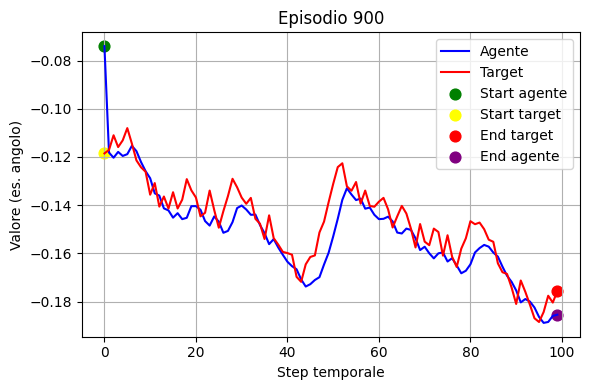

[Episode 901] Steps: 100, Total attached: 97, Mean distance: 0.0191, Success: True
[Episode 902] Steps: 100, Total attached: 94, Mean distance: 0.0191, Success: True
[Episode 903] Steps: 100, Total attached: 77, Mean distance: 0.0192, Success: False
[Episode 904] Steps: 100, Total attached: 98, Mean distance: 0.0191, Success: True
[Episode 905] Steps: 100, Total attached: 80, Mean distance: 0.0192, Success: False
[Episode 906] Steps: 100, Total attached: 95, Mean distance: 0.0192, Success: True
[Episode 907] Steps: 100, Total attached: 72, Mean distance: 0.0192, Success: False
[Episode 908] Steps: 100, Total attached: 88, Mean distance: 0.0192, Success: True
[Episode 909] Steps: 100, Total attached: 95, Mean distance: 0.0192, Success: True
[Episode 910] Steps: 100, Total attached: 90, Mean distance: 0.0192, Success: True
[Episode 911] Steps: 100, Total attached: 84, Mean distance: 0.0192, Success: True
[Episode 912] Steps: 100, Total attached: 83, Mean distance: 0.0192, Success: True
[

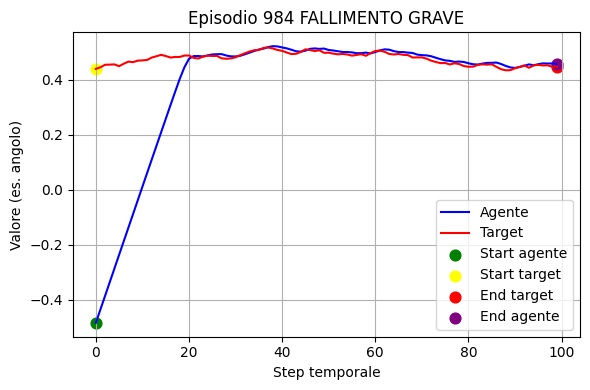

[Episode 984] Steps: 100, Total attached: 69, Mean distance: 0.0196, Success: False
[Episode 985] Steps: 100, Total attached: 97, Mean distance: 0.0196, Success: True
[Episode 986] Steps: 100, Total attached: 76, Mean distance: 0.0196, Success: False
[Episode 987] Steps: 100, Total attached: 86, Mean distance: 0.0196, Success: True
[Episode 988] Steps: 100, Total attached: 93, Mean distance: 0.0196, Success: True
[Episode 989] Steps: 100, Total attached: 86, Mean distance: 0.0196, Success: True
[Episode 990] Steps: 100, Total attached: 92, Mean distance: 0.0196, Success: True
[Episode 991] Steps: 100, Total attached: 99, Mean distance: 0.0196, Success: True
[Episode 992] Steps: 100, Total attached: 98, Mean distance: 0.0196, Success: True
[Episode 993] Steps: 100, Total attached: 88, Mean distance: 0.0196, Success: True
[Episode 994] Steps: 100, Total attached: 93, Mean distance: 0.0196, Success: True
[Episode 995] Steps: 100, Total attached: 95, Mean distance: 0.0196, Success: True
[E

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01_IRL"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


Fail episode 0 with total attached: 0


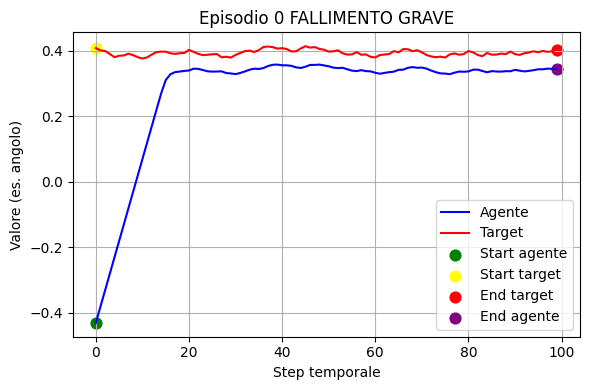

[Episode 0] Steps: 100, Total attached: 0, Mean distance: 0.1081, Success: False


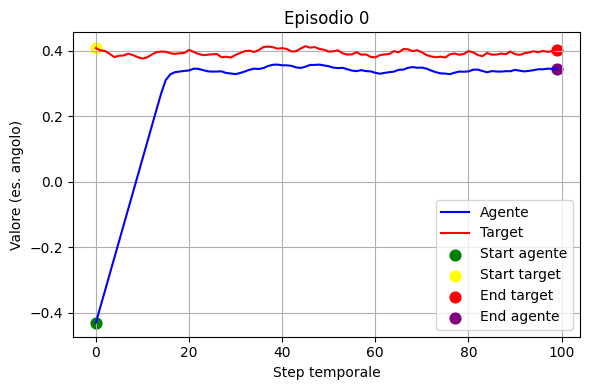

Fail episode 1 with total attached: 0


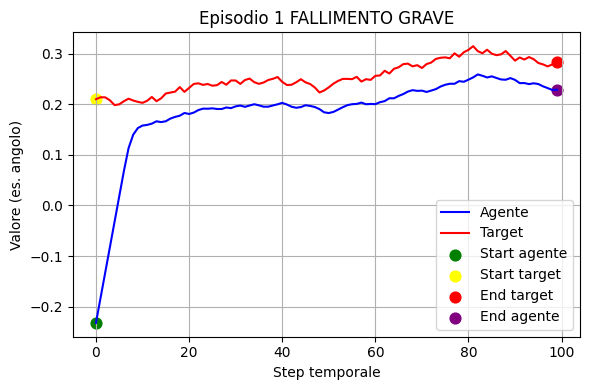

[Episode 1] Steps: 100, Total attached: 0, Mean distance: 0.0854, Success: False
Fail episode 2 with total attached: 0


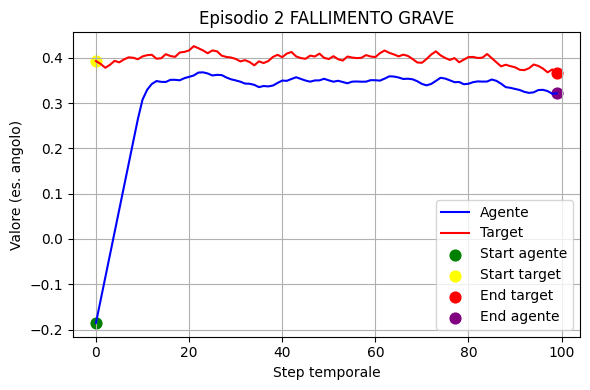

[Episode 2] Steps: 100, Total attached: 0, Mean distance: 0.0828, Success: False
Fail episode 3 with total attached: 0


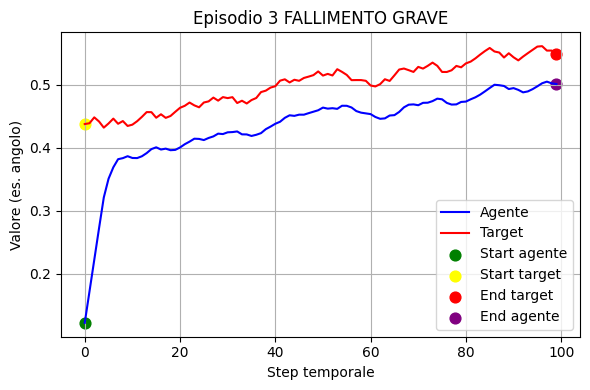

[Episode 3] Steps: 100, Total attached: 0, Mean distance: 0.0773, Success: False
Fail episode 4 with total attached: 1


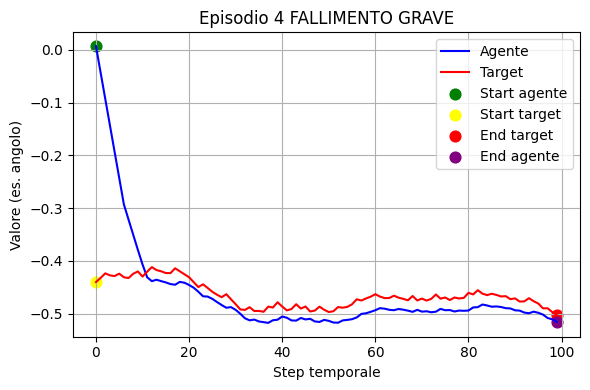

[Episode 4] Steps: 100, Total attached: 1, Mean distance: 0.0695, Success: False
Fail episode 5 with total attached: 2


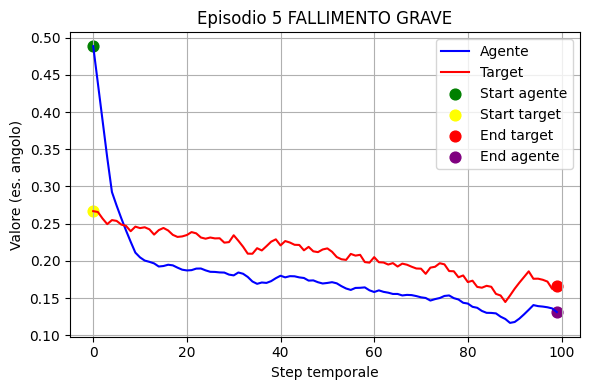

[Episode 5] Steps: 100, Total attached: 2, Mean distance: 0.0650, Success: False
Fail episode 6 with total attached: 48


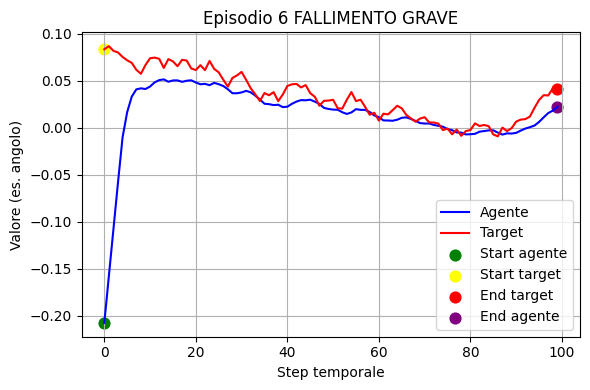

[Episode 6] Steps: 100, Total attached: 48, Mean distance: 0.0583, Success: False
Fail episode 7 with total attached: 0


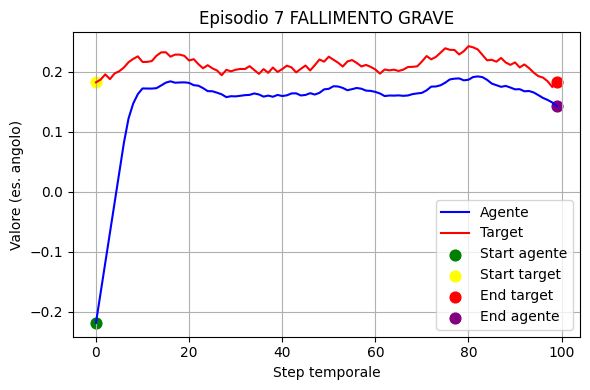

[Episode 7] Steps: 100, Total attached: 0, Mean distance: 0.0580, Success: False
Fail episode 8 with total attached: 1


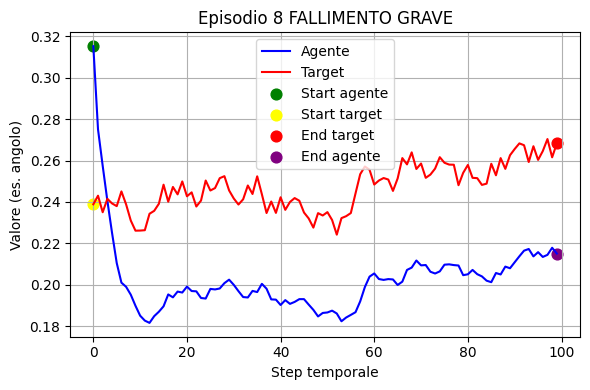

[Episode 8] Steps: 100, Total attached: 1, Mean distance: 0.0567, Success: False
[Episode 9] Steps: 100, Total attached: 77, Mean distance: 0.0519, Success: False
Fail episode 10 with total attached: 0


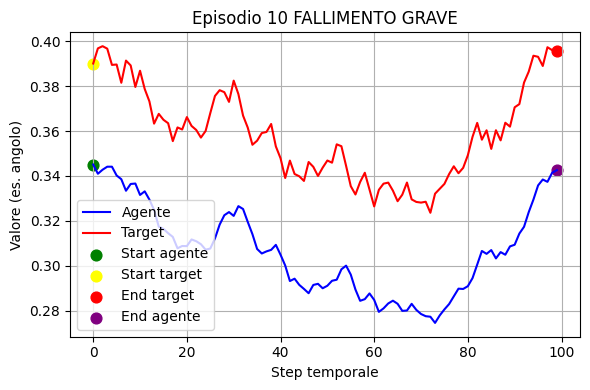

[Episode 10] Steps: 100, Total attached: 0, Mean distance: 0.0519, Success: False
Fail episode 11 with total attached: 0


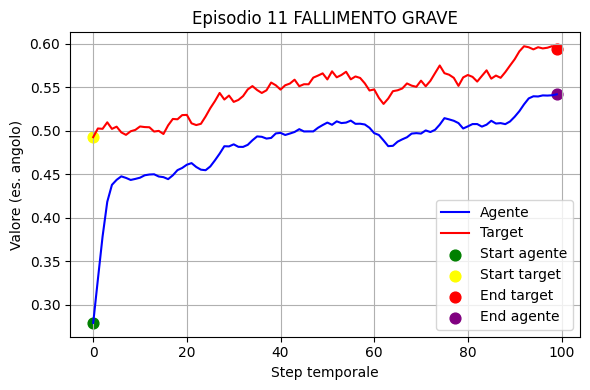

[Episode 11] Steps: 100, Total attached: 0, Mean distance: 0.0523, Success: False
Fail episode 12 with total attached: 3


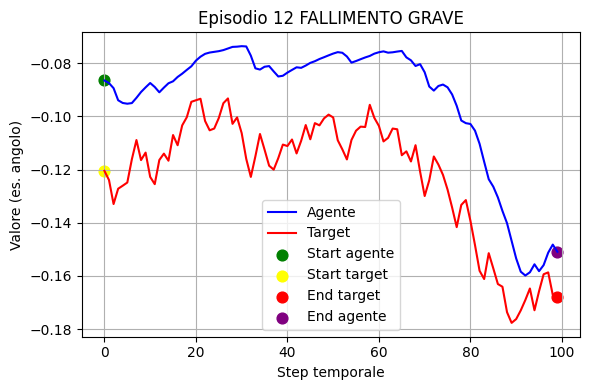

[Episode 12] Steps: 100, Total attached: 3, Mean distance: 0.0504, Success: False
Fail episode 13 with total attached: 1


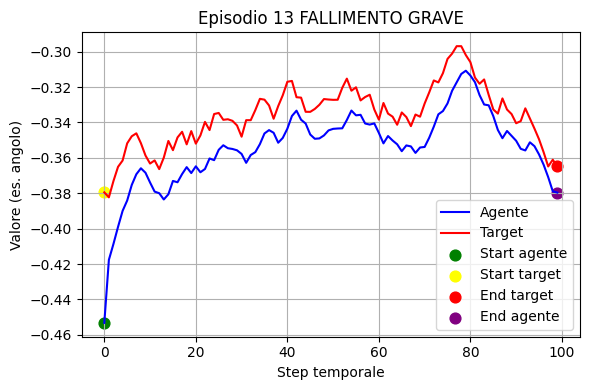

[Episode 13] Steps: 100, Total attached: 1, Mean distance: 0.0481, Success: False
Fail episode 14 with total attached: 6


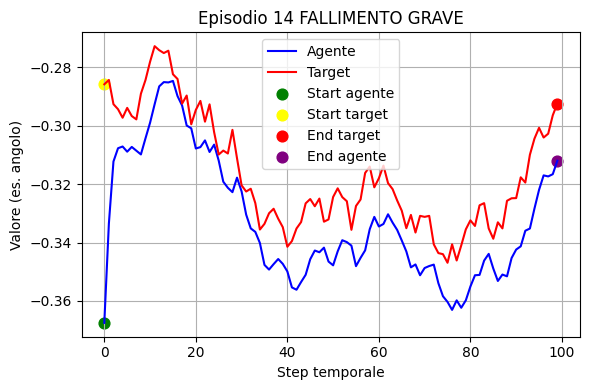

[Episode 14] Steps: 100, Total attached: 6, Mean distance: 0.0459, Success: False
Fail episode 15 with total attached: 7


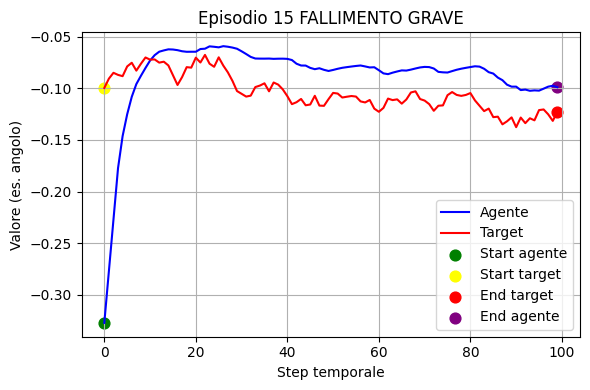

[Episode 15] Steps: 100, Total attached: 7, Mean distance: 0.0449, Success: False
Fail episode 16 with total attached: 38


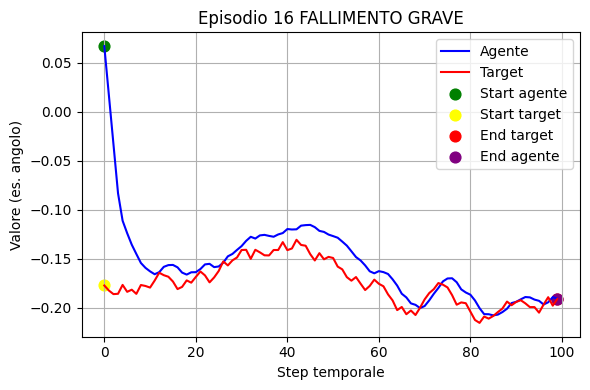

[Episode 16] Steps: 100, Total attached: 38, Mean distance: 0.0433, Success: False
Fail episode 17 with total attached: 1


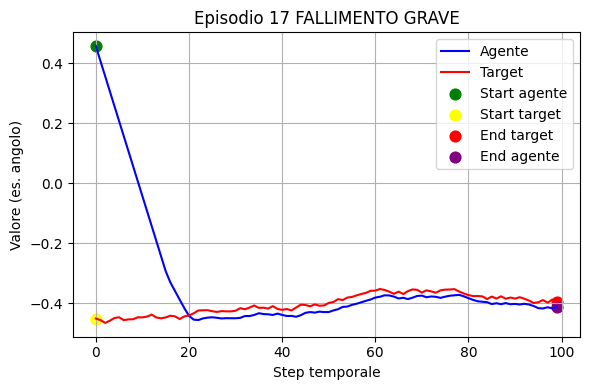

[Episode 17] Steps: 100, Total attached: 1, Mean distance: 0.0463, Success: False
Fail episode 18 with total attached: 0


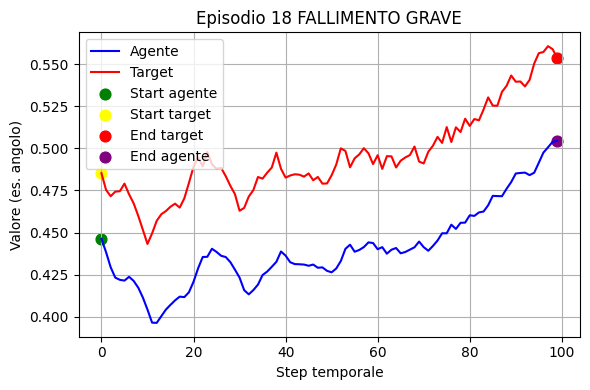

[Episode 18] Steps: 100, Total attached: 0, Mean distance: 0.0467, Success: False
Fail episode 19 with total attached: 2


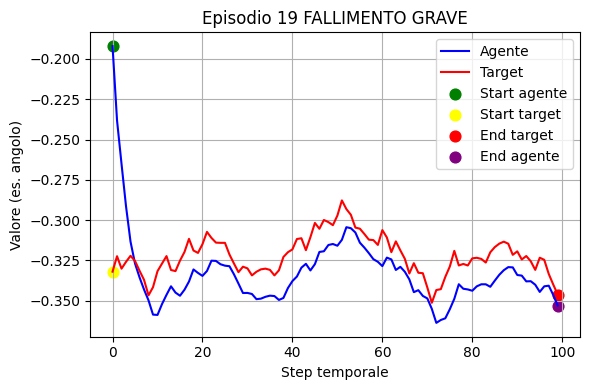

[Episode 19] Steps: 100, Total attached: 2, Mean distance: 0.0452, Success: False
Fail episode 20 with total attached: 17


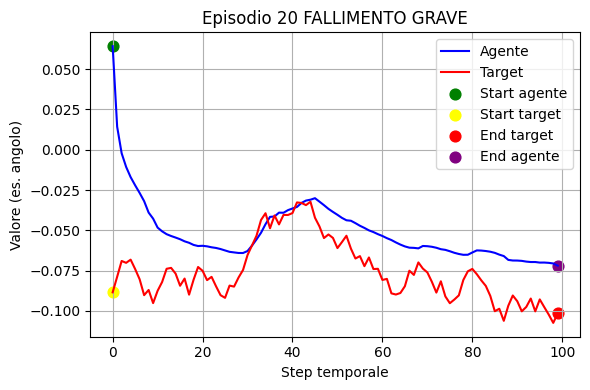

[Episode 20] Steps: 100, Total attached: 17, Mean distance: 0.0441, Success: False
Fail episode 21 with total attached: 1


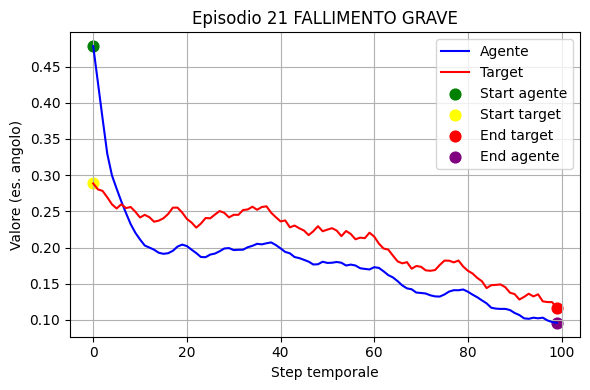

[Episode 21] Steps: 100, Total attached: 1, Mean distance: 0.0440, Success: False
Fail episode 22 with total attached: 63


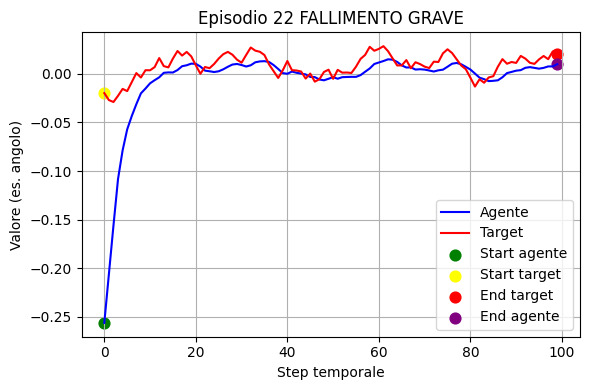

[Episode 22] Steps: 100, Total attached: 63, Mean distance: 0.0426, Success: False
Fail episode 23 with total attached: 0


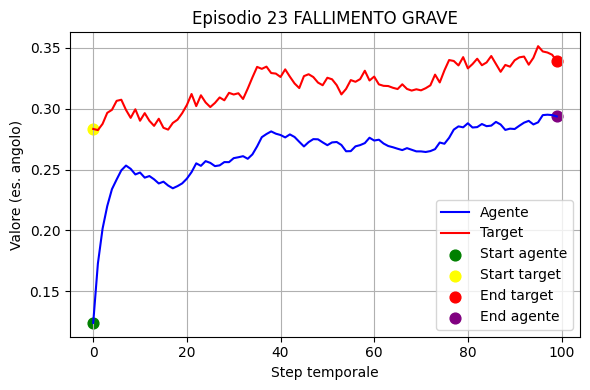

[Episode 23] Steps: 100, Total attached: 0, Mean distance: 0.0430, Success: False
Fail episode 24 with total attached: 0


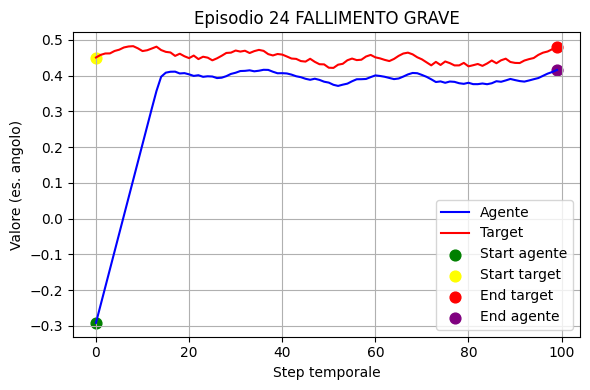

[Episode 24] Steps: 100, Total attached: 0, Mean distance: 0.0453, Success: False
Fail episode 25 with total attached: 0


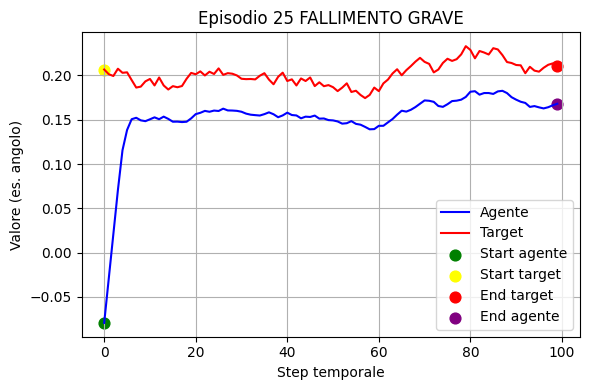

[Episode 25] Steps: 100, Total attached: 0, Mean distance: 0.0454, Success: False
[Episode 26] Steps: 100, Total attached: 71, Mean distance: 0.0443, Success: False
Fail episode 27 with total attached: 36


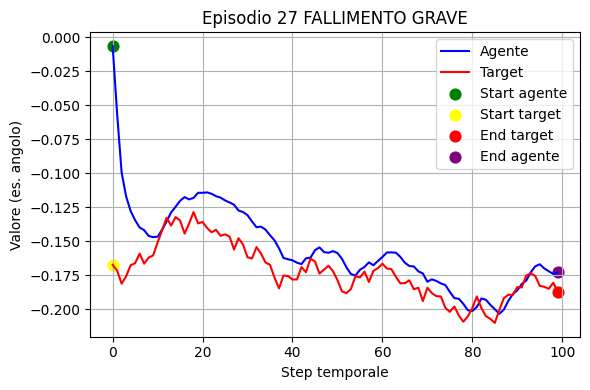

[Episode 27] Steps: 100, Total attached: 36, Mean distance: 0.0432, Success: False
Fail episode 28 with total attached: 24


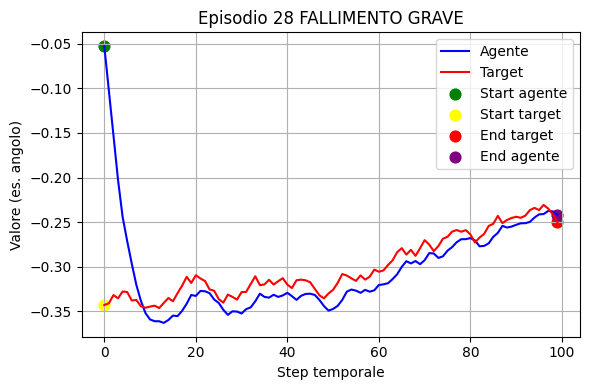

[Episode 28] Steps: 100, Total attached: 24, Mean distance: 0.0424, Success: False
[Episode 29] Steps: 100, Total attached: 84, Mean distance: 0.0412, Success: True
Fail episode 30 with total attached: 2


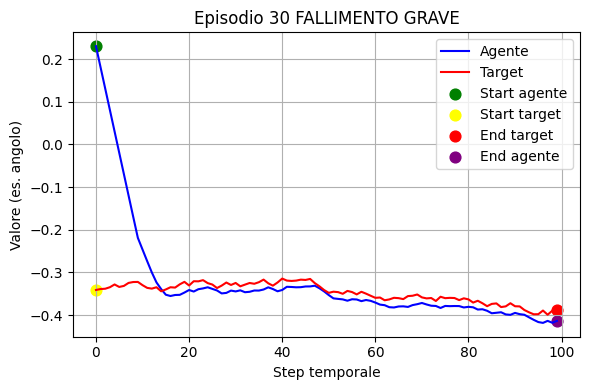

[Episode 30] Steps: 100, Total attached: 2, Mean distance: 0.0413, Success: False
Fail episode 31 with total attached: 1


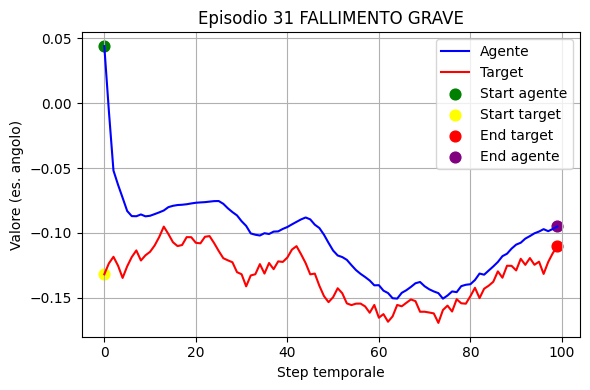

[Episode 31] Steps: 100, Total attached: 1, Mean distance: 0.0409, Success: False
Fail episode 32 with total attached: 0


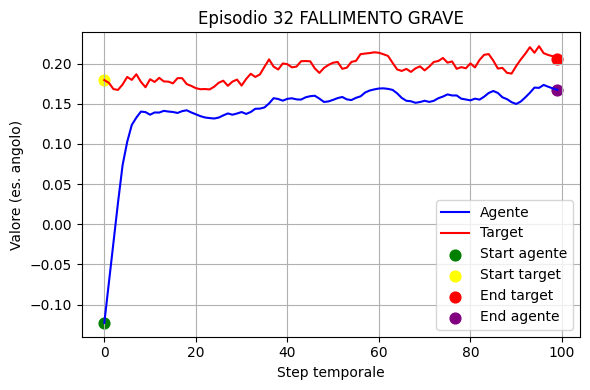

[Episode 32] Steps: 100, Total attached: 0, Mean distance: 0.0410, Success: False
Fail episode 33 with total attached: 53


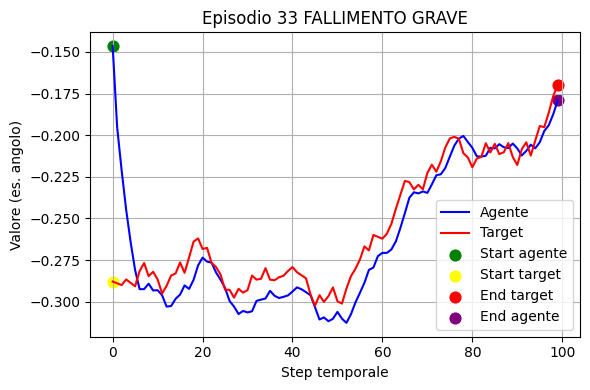

[Episode 33] Steps: 100, Total attached: 53, Mean distance: 0.0401, Success: False
Fail episode 34 with total attached: 0


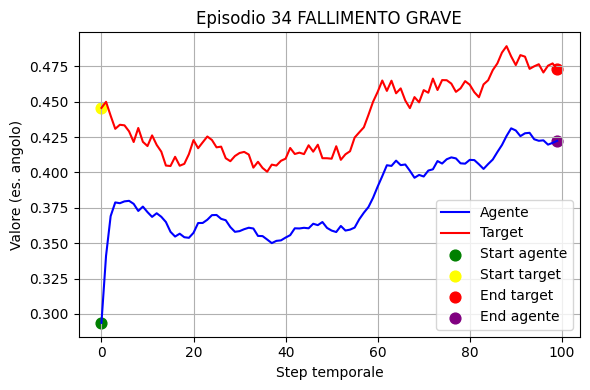

[Episode 34] Steps: 100, Total attached: 0, Mean distance: 0.0405, Success: False
Fail episode 35 with total attached: 6


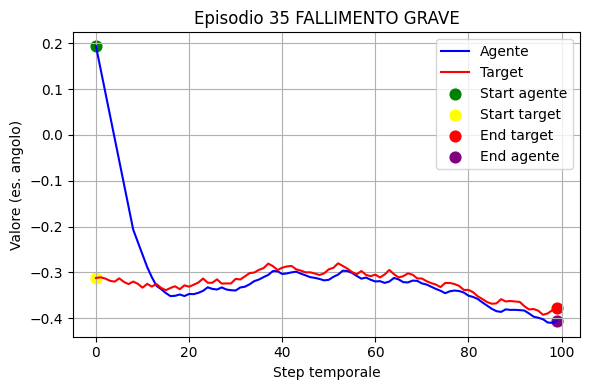

[Episode 35] Steps: 100, Total attached: 6, Mean distance: 0.0405, Success: False
Fail episode 36 with total attached: 8


KeyboardInterrupt: 

<Figure size 600x400 with 0 Axes>

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=1000, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []
    fail = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        if total_attached_counter < 70:
            fail += 1
            print(f"Fail episode {ep} with total attached: {total_attached_counter}")
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep} FALLIMENTO GRAVE")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")
    print(f"Fallimenti gravi (attaccato < 70 step): {fail} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)
